# Census income prediction

## Introduzione

Il progetto mira a definire dei modelli di machine learning in grado di predire lo stato economico sociale sulla base di alcune caratteristiche, quali titolo di studio, età, paese di origine, ore lavorate alla settimana ecc. Il dataset (presente sia su Kaggle che su UCI) raccoglie dati inerenti a una porzione di cittadini statunitensi prelevati dal US Census Bureau per l'anno 1994 (in aggiornamento).

Il nostro dataset è etichettato con due valori: <=50k, >50k. Queste due etichette indicano il guadagno annuale in migliaia di dollari di un lavoratore statunitense.
Le feature del dataset sono:
 - age: età della persona
 - workclass: macro categoria di tipo di lavoratore (a livello burocratico)
 - fnlwgt: peso assegnato dal US Census Bureau che indica quanto una certa istanza rappresenta la popolazione (questa colonna non verrà usata come una feature)
 - education: livello di istruzione
 - education-num: numero di anni spesi nel mondo dell'istruzione
 - marital-status: stato civile
 - occupation: macro categoria di lavoro (a livello di settore)
 - relationship: ruolo familiare
 - race: etnia di appartenenza
 - sex: genere registrato
 - capital-gain: entrate economiche al di fuori del lavoro (es: investimento)
 - capital-loss: perdite economiche al di fuori del lavoro
 - hours-per-week: numero di ore lavorate alla settimana
 - native-country: paese di origine 

Come possiamo notare il dataset può essere ridondante

## Analisi esplorativa

Per iniziare esploriamo le librerie necessarie

In [909]:
import warnings
warnings.filterwarnings('ignore')

In [910]:
!pip3 install -U ucimlrepo 
!pip install imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter
from io import StringIO
from ucimlrepo import fetch_ucirepo 
import seaborn as sns
import scipy.stats as st

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


Scarichiamo da UCI il dataset 'Census Income' e studiamone alcune proprietà: abbiamo diversi tipi di dati e alcuni valori mancanti

In [911]:
# scarichiamo il dataset
dataset = fetch_ucirepo(id=2) 
  
# suddivisone del dataset in features e target come dataframe
X = dataset.data.features 
y = dataset.data.targets 


print(dataset.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [912]:
# osserviamo alcune informazioni generiche sul dataset
print(dataset.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

In [913]:
# osserviamo il dataset
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [914]:
# osserviamo il target
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48837,<=50K.
48838,<=50K.
48839,<=50K.
48840,<=50K.


Uniamo i due dataframe per lavorarci in questa fase iniziale

In [915]:
df = pd.concat([X, y], axis=1)

# esportiamo il dataset in un file csv 
df.to_csv('dataset.csv')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Osserviamo la forma del dataset: il numero di feature è consistente

In [916]:
df.shape

(48842, 15)

Cerchiamo maggiori informazioni sul dataset, come il tipo delle feature

In [917]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Osserviamo le statistiche dei tipi numerici. Ricordiamoci che fnlwgt non va pensata come una feature, bensì come a un peso di ogni record

In [918]:
df.describe().drop(labels=['education-num'], axis=1).round(1)

,age,fnlwgt,capital-gain,capital-loss,hours-per-week
count,48842.0,48842.0,48842.0,48842.0,48842.0
mean,38.6,189664.1,1079.1,87.5,40.4
std,13.7,105604.0,7452.0,403.0,12.4
min,17.0,12285.0,0.0,0.0,1.0
25%,28.0,117550.5,0.0,0.0,40.0
50%,37.0,178144.5,0.0,0.0,40.0
75%,48.0,237642.0,0.0,0.0,45.0
max,90.0,1490400.0,99999.0,4356.0,99.0


Cerchiamo eventuali valori duplicati

In [919]:
df.duplicated().sum()

29

Cerchiamo eventuali valori nulli

In [920]:
df.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Cerchiamo eventuali valori nan

In [921]:
df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Alcuni valori mancanti sono indicanti sono indicati con '?', mentre alti con ',,' in ogni caso stanti ad indicare NaN. La differenza tra queste due notazioni verrà trattata più avanti.

Verifichiamo il bilanciamento del dataset

<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64


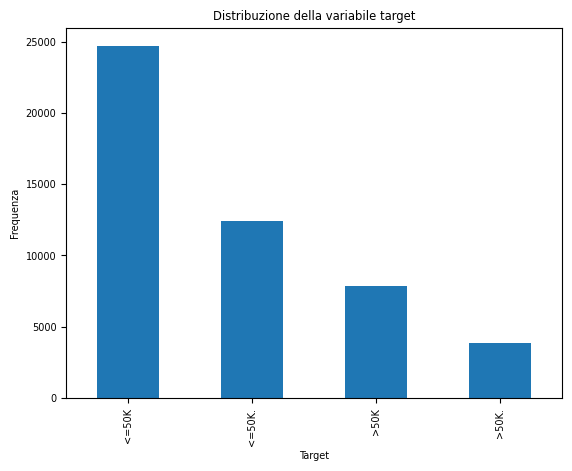

In [922]:
conteggio_valori = df['income'].value_counts()
print(conteggio_valori)

conteggio_valori.plot(kind='bar')
plt.title('Distribuzione della variabile target')
plt.xlabel('Target')
plt.ylabel('Frequenza')
plt.show()

Notiamo che la colonna 'income' presenta più di due valori: accorperemo '<=50K' e '<=50K.' nello stesso valore. Lo stesso vale per '>50K' e '>50K.'
Il nostro problema è binario: definiamo true quando il guadagno è maggiore di 50k, false quando è minore o uguale. 

## Data Visualization

#### Distribuzione variabili

Ora procediamo a visualizzare le statistiche del dataset. Il primo tipo di grafico che scegliamo è quello che ci mostra la distribuzione individuale delle variabili. Dalla visualizzazione escludiamo 'education-num' poichè come vedremo più avanti contiene le stesse informazioni di 'education', 'native country' per rendere più pulita la realizzazione dei grafici. Infine 'fnlwgt' non è una feature, bensì un peso e non ha senso considerarlo come le altre feature, tuttavia lo visualizziamo per farci comunque un'idea

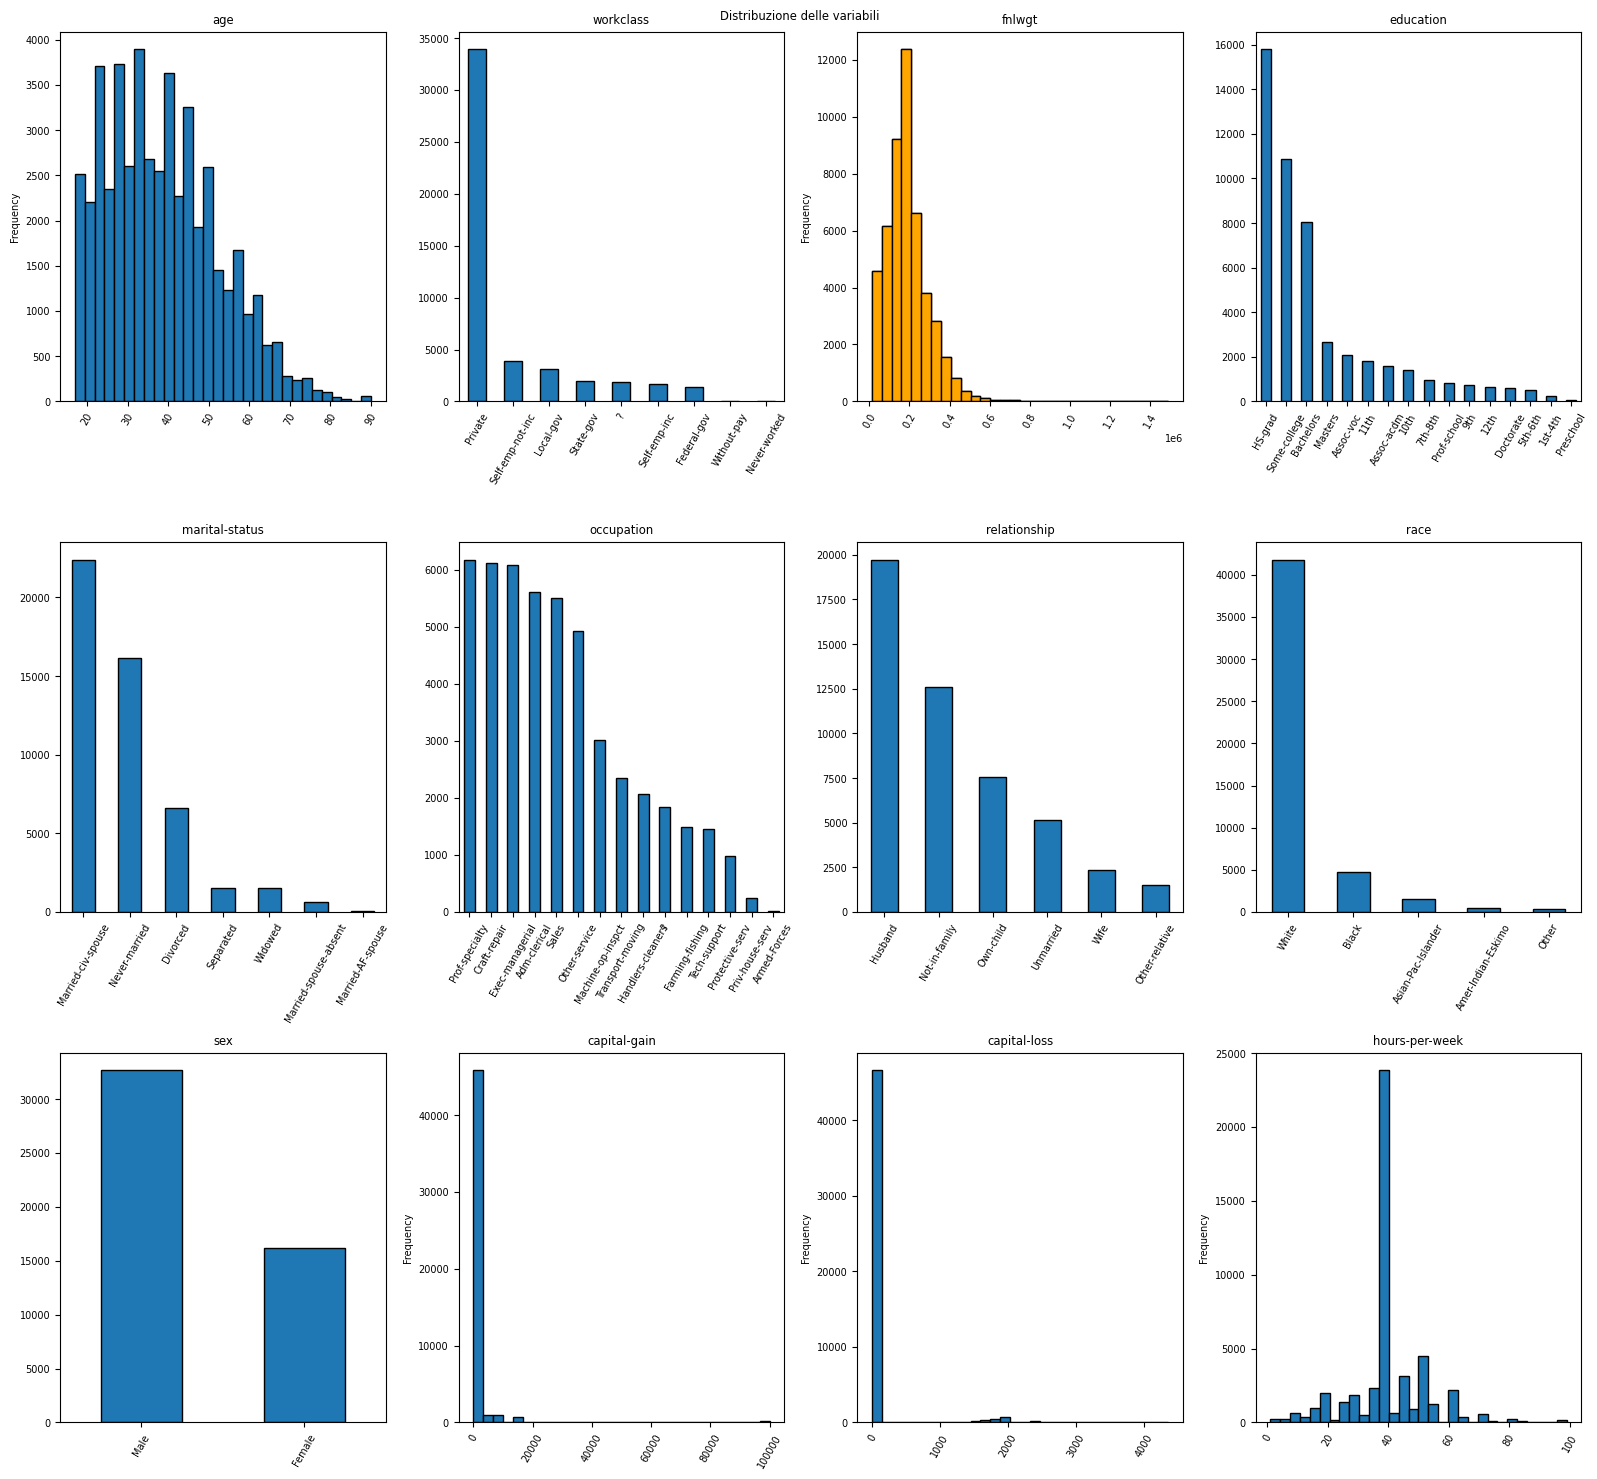

In [923]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 15))
fig.suptitle("Distribuzione delle variabili")


i, j = 0, 0
for column in df.columns.drop(labels=["income", "native-country", "education-num"]):
    if (df[column].dtype == 'int64'):
        df[column].plot.hist(ax=axes[i, j], bins=30, edgecolor="black")
        # grafico di colore diverso per fnlwgt
        if column == 'fnlwgt':
            df[column].plot.hist(ax=axes[i, j], bins=30, edgecolor="black", color="orange")
    else:
        df[column].value_counts().plot.bar(ax=axes[i, j], edgecolor="black")

    axes[i, j].set_title(column)
    axes[i, j].tick_params(axis='x', rotation=60)

    # aggiornmento indici
    j += 1
    if j == 4:
        i += 1
        j = 0


plt.tight_layout()
plt.show()

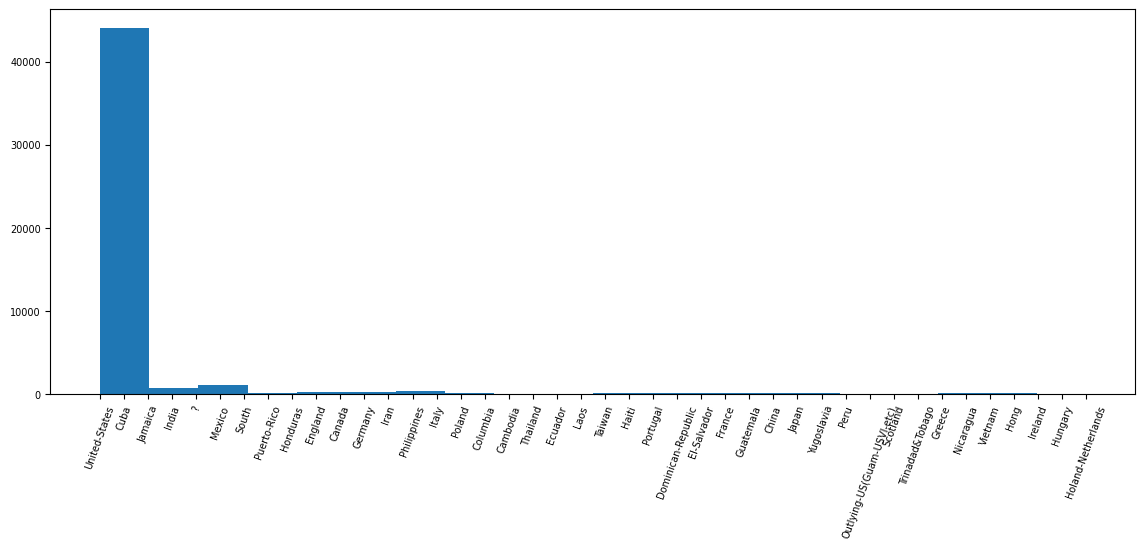

In [924]:
# plotto separatamente native-country
plt.figure(figsize=(14, 5))  

plt.hist(df['native-country'].dropna(), bins=20, label='Native country')
plt.xticks(rotation=70)  
plt.show()

Alcune considerazioni che si possono fare in merito alla distribuzione dei dati:
 - la fascia di età maggiormente rappresentata va dai 18 ai 50 anni circa
 - i privati sono i tipi di contratti maggiormente diffusi
 - il titolo di studio più comune è il diploma
 - lo stato civile più rappresentato è quello di persone sposate
 - l'etnia più rappresentata è quella bianca
 - il genere più rappresentato è quello maschile
 - è difficile guadagnare (o perdere) tanto capitale all'esterno del mondo del lavoro (comunque sono entrambi 0 nella maggior parte dei casi)
 - la maggior parte delle persone lavora 40 ore a settimana
 - il paese di provenienza più rappresentato sono gli Stati Uniti

#### Boxplot

Continuiamo ora con i boxplot per la visualizzazione di eventuali outliers. Per quanto riguarda i boxplot osserviamo solo i dati di natura numerica. Inoltre non ha senso osservare 'education-num' perchè è la codifica numerica del titolo di studio, però osserviamo 'fnlwgt' prestando attenzione a pensarlo come a un peso anzichè come a una feature.

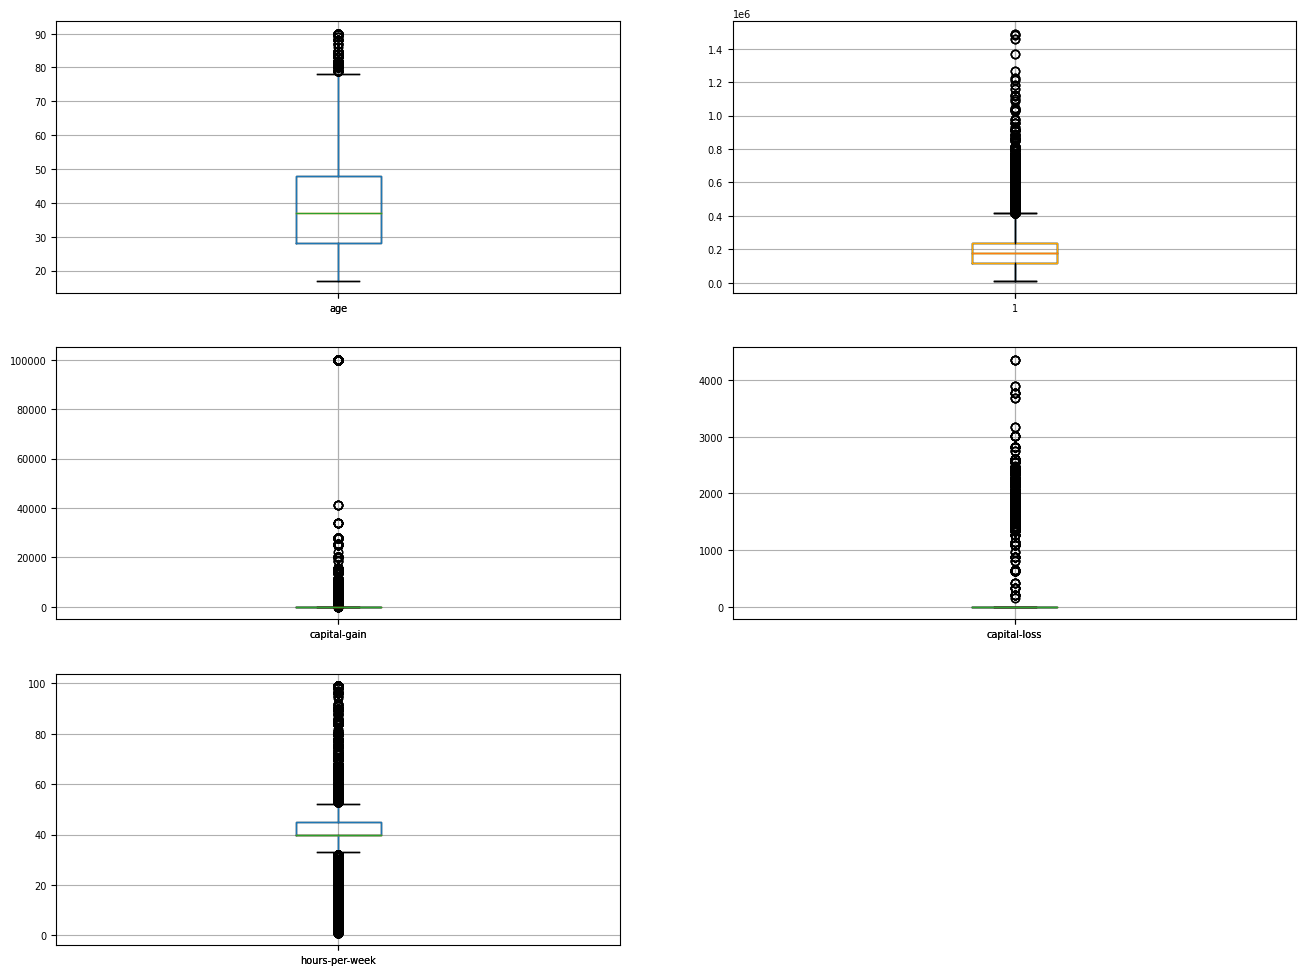

In [925]:
plt.figure(figsize=(16, 12))
plt.rc('font', size=7)

i = 0
for column in df.select_dtypes(include=['int64', 'float64']).columns.drop(labels=['education-num']):
    graphic = plt.subplot(3, 2, i + 1)
    graphic.boxplot(df[column])
    df[column].to_frame().boxplot()
    # grafico di colore diverso per fnlwgt
    if column == 'fnlwgt':
        graphic.boxplot(df[column])['boxes'][0].set(color='orange')
    i = i + 1

plt.show()

Definiamo la funzione 'find_outliers' che usiamo per trovare gli outliers nel dataset

In [926]:
def find_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    medium_weight = outliers['fnlwgt'].mean().astype('int64')

    return outliers, medium_weight

In [927]:
for numeric_column in df.select_dtypes(include='int64').columns.drop(labels=['education-num']).to_list():
    outliers, medium_weight = find_outliers(numeric_column)
    print('Number of outliers in ',numeric_column,' is: ', len(outliers),' and their medium weight is:',medium_weight)

print('\n')
print('Average weight of dataset is:', df['fnlwgt'].mean().astype('int64'), ', +-', df['fnlwgt'].std().astype('int64'))

Number of outliers in  age  is:  216  and their medium weight is: 155606
Number of outliers in  fnlwgt  is:  1453  and their medium weight is: 515040
Number of outliers in  capital-gain  is:  4035  and their medium weight is: 187001
Number of outliers in  capital-loss  is:  2282  and their medium weight is: 188025
Number of outliers in  hours-per-week  is:  13496  and their medium weight is: 185293


Average weight of dataset is: 189664 , +- 105604


Delle quattro feature studiate si può dire che:
 - l'età media è di circa 38 anni e sono presenti outliers superiori
 - i capital loss e gain medi sono vicini a 0, ma esistono outliers superiori
 - le ore medie lavorate sono 40, ma esistono eccezioni sia superiori che inferiori
 - il valore medio di fnlwgt è 189000, ma gli outliers (solo superiori) hanno un valore molto grande

Gli outliers di age, capital-gain, capital-loss e hours-per-week hanno un peso che non si discosta molto dalla media del peso del dataset.
Anche la stessa colonna fnlwgt ha degli outliers, ma ricordiamoci che fnlwgt non è una feature: eliminare gli outliers di fnlwgt significherebbe distorcere la rappresentazione della popolazione.
Gli outliers delle altre colonne sono molti e sarà necessario gestirli.

### Statistiche bivariate

#### Distribuzione in funzione di target
Ora osserivamo la relazione che c'è tra la colonna target 'income' e le altre colonne del dataset. Nel fare ciò escludiamo nuovamente 'education-num' e riportiamo invece fnlwgt per verificare la distribuzione del target in rapporto ai pesi.

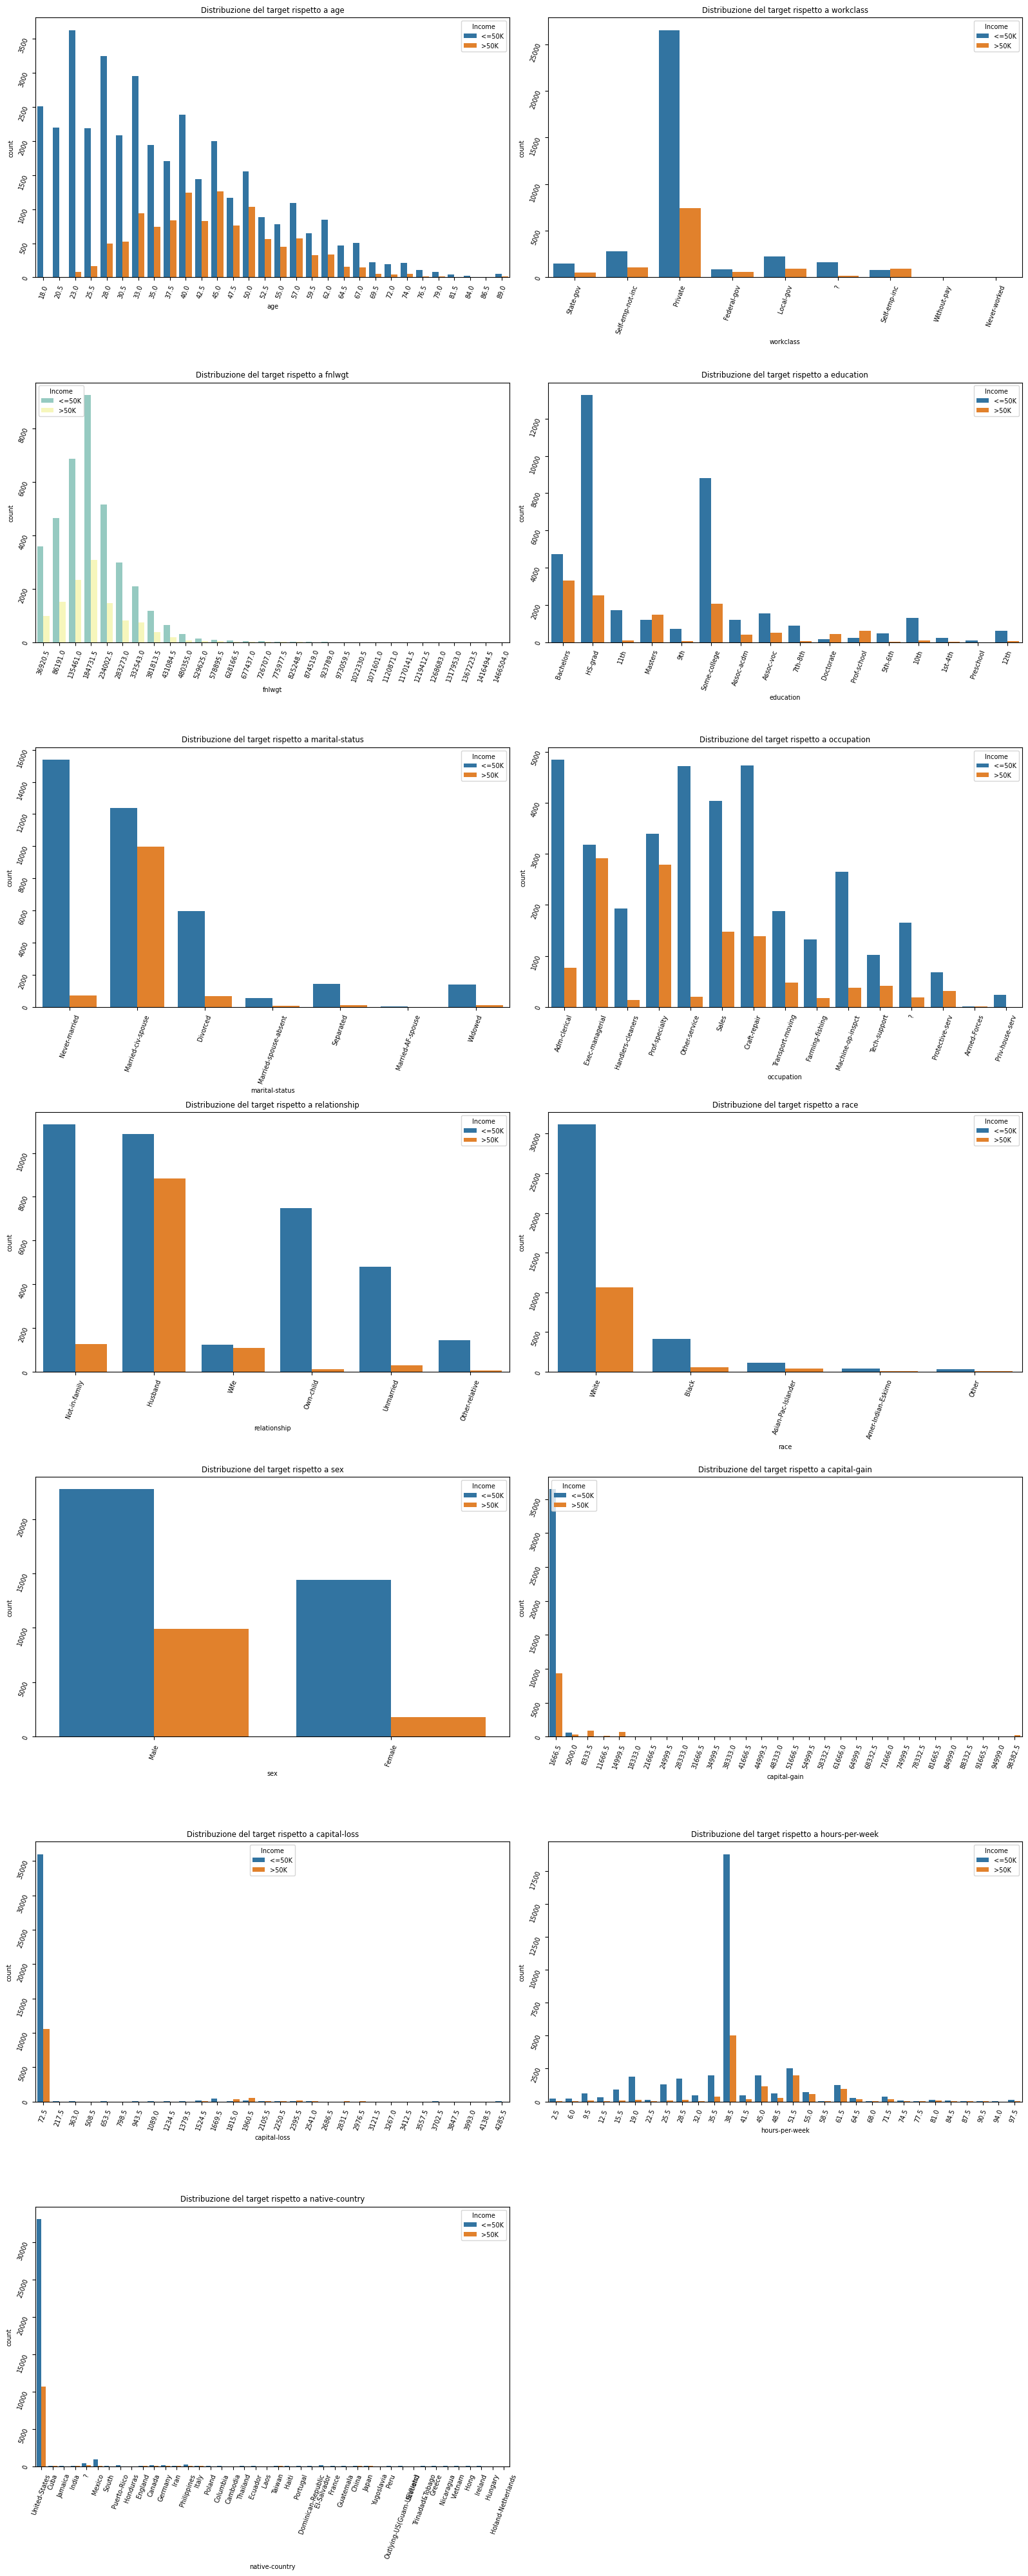

In [928]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 40))
for colonna, ax in zip(df.columns.drop(labels=["income", "education-num"]), axes.flatten()):
    ax.set_ylabel('Frequenza')
    ax.set_title(f'Distribuzione del target rispetto a {colonna}')
    
    if df[colonna].dtype == 'object':
        sns.countplot(data=df, x=colonna, hue=df['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'}), ax=ax)
    else:
        intervalli = pd.cut(df[colonna], right=False, bins=30, duplicates='drop', precision=0).apply(lambda intervallo: intervallo.mid)
        # grafico di colore diverso per fnlwgt
        if colonna == 'fnlwgt':
            sns.countplot(data=df, x=intervalli, hue=df['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'}), ax=ax, palette='Set3')
        else:
            sns.countplot(data=df, x=intervalli, hue=df['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'}), ax=ax)
        
    ax.tick_params(rotation=70)    
    ax.legend(title='Income')

fig.delaxes(axes[6, 1])

plt.tight_layout()
plt.show()

Definiamo una funzione 'stats' da usare per calcolare le statistiche delle feature in rapporto a 'income' in modo più accurato


In [929]:
def stats(x):
    Coloumn_To_Aggregate=[x,'income']
    temp_df = df.copy()
    temp_df['income'] = temp_df['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'})
    df6=pd.merge(temp_df.groupby(Coloumn_To_Aggregate).size().reset_index(name='ind_siz'), 
                 temp_df.groupby(Coloumn_To_Aggregate[:-1]).size().reset_index(name='Total'), on =Coloumn_To_Aggregate[:-1])
    df6['Category_Percent']=round((df6['ind_siz']/df6['Total'])*100 ,2)
    temp2=df6[[x,'income','Category_Percent']]
    return temp2.pivot(columns=x,index='income')

In [930]:
for column in df.columns.drop(labels=['education-num', 'fnlwgt', 'income']):
    display(stats(column))

Category_Percent                                                   \
age                  17     18     19     20     21     22     23     24   
income                                                                     
<=50K             100.0  100.0  99.72  99.91  99.45  98.56  98.34  96.35   
>50K                NaN    NaN   0.28   0.09   0.55   1.44   1.66   3.65   

                      ...                                                  \
age        25     26  ...     81     82     83     84    85     86     87   
income                ...                                                   
<=50K   93.64  92.63  ...  81.08  100.0  81.82  92.31  80.0  100.0  100.0   
>50K     6.36   7.37  ...  18.92    NaN  18.18   7.69  20.0    NaN    NaN   

                             
age        88     89     90  
income                       
<=50K   83.33  100.0  76.36  
>50K    16.67    NaN  23.64  

[2 rows x 74 columns]

Category_Percent                                             \
workclass                ? Federal-gov Local-gov Never-worked Private   
income                                                                  
<=50K                 89.6       60.82     70.44        100.0   78.21   
>50K                  10.4       39.18     29.56          NaN   21.79   

                                                               
workclass Self-emp-inc Self-emp-not-inc State-gov Without-pay  
income                                                         
<=50K            44.66            72.11     73.25       90.48  
>50K             55.34            27.89     26.75        9.52

Category_Percent                                               \
education             10th   11th   12th 1st-4th 5th-6th 7th-8th    9th   
income                                                                    
<=50K                93.74  94.92  92.69   96.76    94.7   93.51  94.58   
>50K                  6.26   5.08   7.31    3.24     5.3    6.49   5.42   

                                                                              \
education Assoc-acdm Assoc-voc Bachelors Doctorate HS-grad Masters Preschool   
income                                                                         
<=50K           74.2     74.67     58.72     27.44   84.14   45.09      98.8   
>50K            25.8     25.33     41.28     72.56   15.86   54.91       1.2   

                                    
education Prof-school Some-college  
income                              
<=50K           26.02        81.04  
>50K            73.98        18.96

Category_Percent                                       \
marital-status         Divorced Married-AF-spouse Married-civ-spouse   
income                                                                 
<=50K                     89.88             62.16              55.39   
>50K                      10.12             37.84              44.61   

                                                                      
marital-status Married-spouse-absent Never-married Separated Widowed  
income                                                                
<=50K                          90.76         95.45     93.53   91.57  
>50K                            9.24          4.55      6.47    8.43

Category_Percent                                         \
occupation                ? Adm-clerical Armed-Forces Craft-repair   
income                                                               
<=50K                 89.64        86.31        66.67        77.37   
>50K                  10.36        13.69        33.33        22.63   

                                                              \
occupation Exec-managerial Farming-fishing Handlers-cleaners   
income                                                         
<=50K                52.22           88.39             93.34   
>50K                 47.78           11.61              6.66   

                                                                           \
occupation Machine-op-inspct Other-service Priv-house-serv Prof-specialty   
income                                                                      
<=50K                  87.69         95.86           98.76          54.89   
>50K                   12.31          4.14            1.24          45.11   

                                                                
occupation Protective-serv Sales Tech-support Transport-moving  
income                                                          
<=50K                68.67  73.2        70.95            79.58  
>50K                 31.33  26.8        29.05            20.42

Category_Percent                                         \
relationship          Husband Not-in-family Other-relative Own-child   
income                                                                 
<=50K                   55.13         89.86          96.55     98.54   
>50K                    44.87         10.14           3.45      1.46   

                               
relationship Unmarried   Wife  
income                         
<=50K            93.97  53.11  
>50K              6.03  46.89

Category_Percent                                       
race   Amer-Indian-Eskimo Asian-Pac-Islander  Black  Other White
income                                                          
<=50K                88.3              73.07  87.92  87.68  74.6
>50K                 11.7              26.93  12.08  12.32  25.4

Category_Percent       
sex              Female   Male
income                        
<=50K             89.07  69.62
>50K              10.93  30.38

Category_Percent                                            \
capital-gain            0      114    401    594    914    991    1055    
income                                                                    
<=50K                   79.48  100.0  100.0  100.0  100.0  100.0  100.0   
>50K                    20.52    NaN    NaN    NaN    NaN    NaN    NaN   

                                   ...                                     \
capital-gain  1086   1111   1151   ...  15831  18481  20051  22040  25124   
income                             ...                                      
<=50K         100.0  100.0  100.0  ...    NaN    NaN    NaN  100.0    NaN   
>50K            NaN    NaN    NaN  ...  100.0  100.0  100.0    NaN  100.0   

                                                 
capital-gain  25236  27828  34095  41310  99999  
income                                           
<=50K           NaN    NaN  100.0  100.0    NaN  
>50K          100.0  100.0    NaN    NaN  100.0  

[2 rows x 123 columns]

Category_Percent                                                  \
capital-loss             0      155    213    323    419    625   653    810    
income                                                                          
<=50K                   77.36  100.0  100.0  100.0  100.0  100.0  50.0  100.0   
>50K                    22.64    NaN    NaN    NaN    NaN    NaN  50.0    NaN   

                            ...                                            \
capital-loss   880    974   ...   2559   2603   2754   2824   3004   3175   
income                      ...                                             
<=50K         100.0  100.0  ...    NaN  100.0  100.0    NaN    NaN  100.0   
>50K            NaN    NaN  ...  100.0    NaN    NaN  100.0  100.0    NaN   

                                         
capital-loss  3683   3770   3900   4356  
income                                   
<=50K         50.0  100.0  100.0  100.0  
>50K          50.0    NaN    NaN    NaN  

[2 rows x 99 columns]

Category_Percent                                            \
hours-per-week               1      2      3      4      5      6      7    
income                                                                      
<=50K                     88.89  77.36  94.92  92.86  90.53  89.13  84.44   
>50K                      11.11  22.64   5.08   7.14   9.47  10.87  15.56   

                                     ...                                     \
hours-per-week     8      9      10  ...     89     90     91     92     94   
income                               ...                                      
<=50K           91.28  88.89  92.24  ...  33.33  59.52  100.0  66.67  100.0   
>50K             8.72  11.11   7.76  ...  66.67  40.48    NaN  33.33    NaN   

                                                 
hours-per-week    95     96    97     98     99  
income                                           
<=50K           50.0  88.89  50.0  78.57  70.07  
>50K            50.0  11.11  50.0  21.43  29.93  

[2 rows x 96 columns]

Category_Percent                                         \
native-country                ? Cambodia Canada  China Columbia   Cuba   
income                                                                   
<=50K                     74.96    67.86  65.38  70.49    95.29  75.36   
>50K                      25.04    32.14  34.62  29.51     4.71  24.64   

                                                               ...           \
native-country Dominican-Republic Ecuador El-Salvador England  ... Portugal   
income                                                         ...            
<=50K                       95.15   86.67        92.9   62.99  ...    82.09   
>50K                         4.85   13.33         7.1   37.01  ...    17.91   

                                                                            \
native-country Puerto-Rico Scotland  South Taiwan Thailand Trinadad&Tobago   
income                                                                       
<=50K                89.13    85.71  82.61   60.0    83.33           92.59   
>50K                 10.87    14.29  17.39   40.0    16.67            7.41   

                                                 
native-country United-States Vietnam Yugoslavia  
income                                           
<=50K                   75.6   91.86      65.22  
>50K                    24.4    8.14      34.78  

[2 rows x 42 columns]

Si possono fare una serie di considerazioni in merito al rapporto tra la soglia di guadagno individuale e le condizioni personali:
 - l'età è un fattore molto correlato al guadagno, ciò che emerge è che a guadagnare meno di 50.000 dollari l'anno sono giovani ed anziani, mentre le fasce di età intermedie (presumibilmente in carriera) presentano più persone che guadagnano almeno tale cifra.
 - chi lavora in proprio (es: freelancer, ha uno studio proprio) è più probabile che guadagni almeno 50.000 dollari l'anno, mentre per gli altri tipi è molto più probabile guadagnare meno
 - esistono più i laureati (magistrale), dottorati e insegnanti scolastici che guadagnano più di 50.000 dollari l'anno rispetto a quelli che ne guadagno meno. La categoria dei laureati triennali tende a guadagnare meno di 50.000 dollari l'anno, tuttavia è la categoria con maggiore equilibrio
 - gli insegnanti specializzati e le posizioni manageriali sono le categorie più equilibrate tra chi guadagna più e meno di 50.000 dollari l'anno, mentre le categorie meno equilibrate sono quelle che lavorano in ambito amministrativo, clericale e "altri servizi"
 - le persone sposate hanno una probabilità vicina al 50% di guadagnare almeno 50.000 dollari l'anno, negli altri casi meno
 - circa un individuo di etnia bianca su 4 guadagna almeno 50.000 dollari l'anno. Per le altre etnie (eccetto asian-pac-island) tale rapporto è più piccolo
 - circa un maschio su 3 guadagna almeno 50.000 dollari l'anno, mentre per le donne il rapporto è di circa 1 su 10

Si noti che in merito a fnlwgt i valori del target seguono curve simili: ciò significa che le istanze del dataset sono pesate a prescindere dal loro guadagno.

#### Boxplot bivariati

Ora procediamo con dei boxplot in cui includiamo il confronto con la colonna target

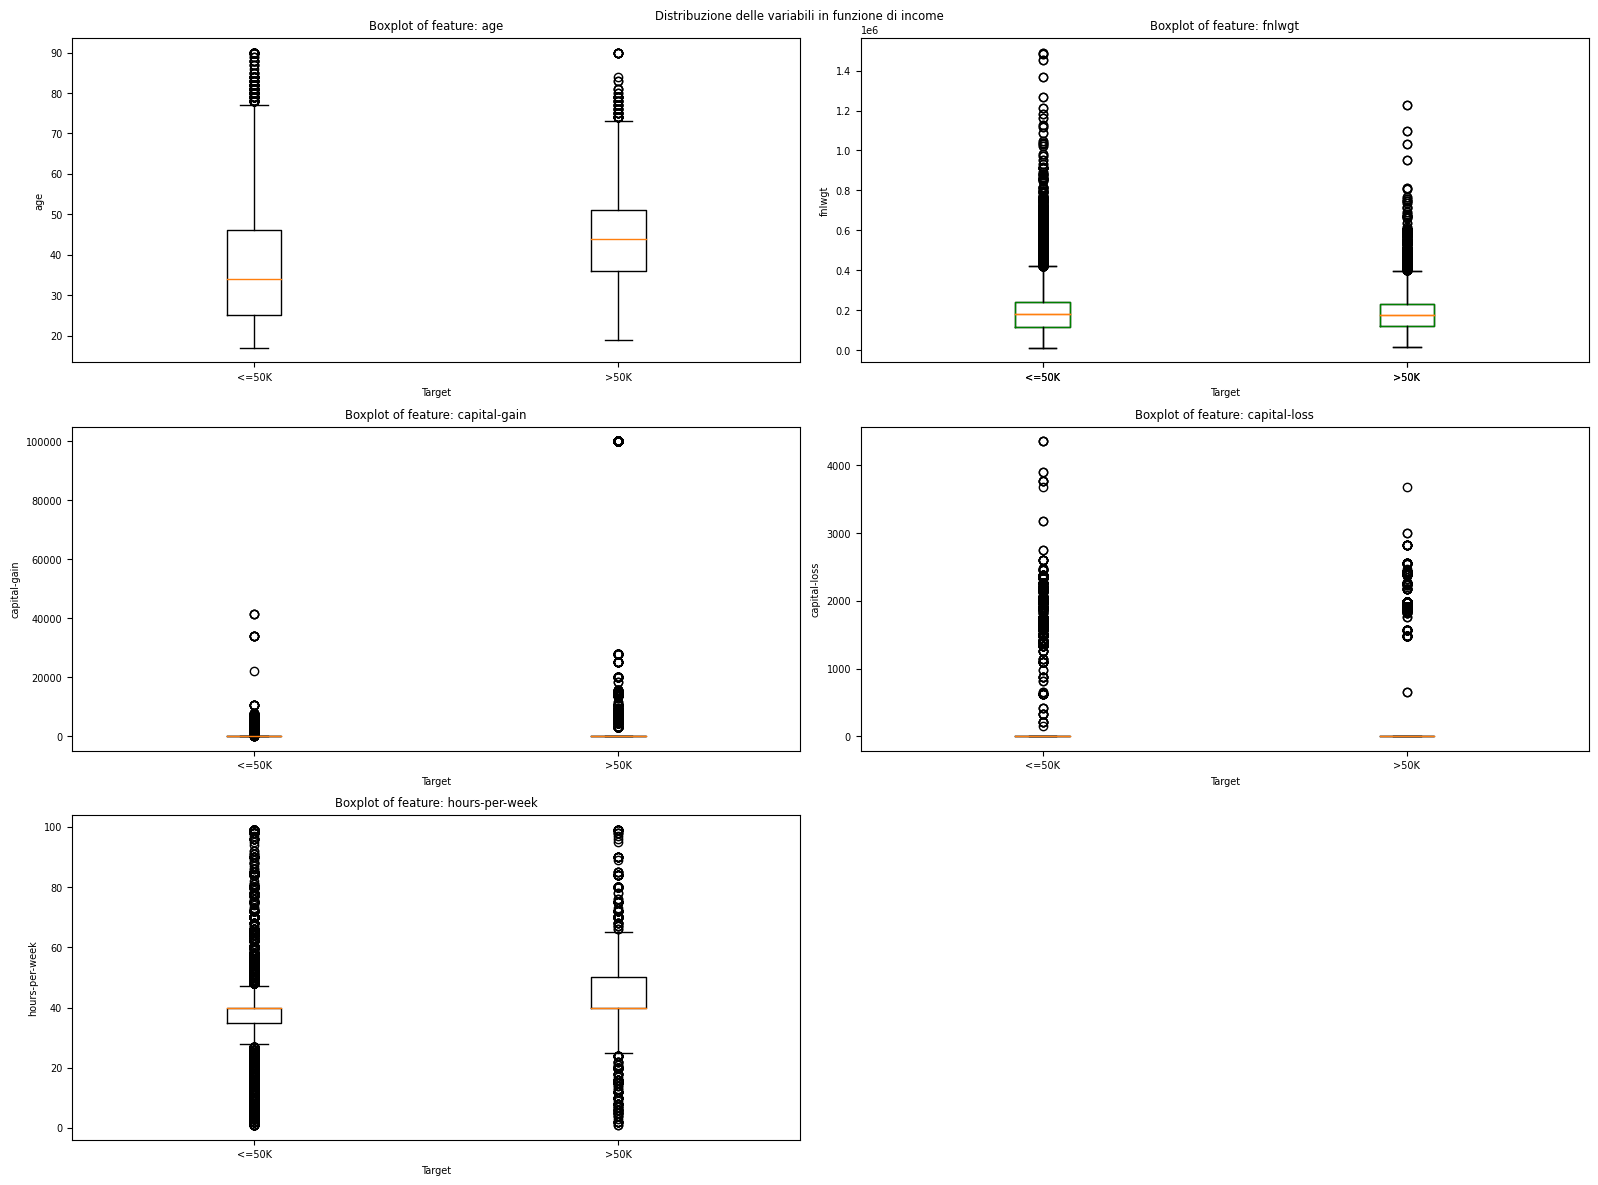

In [936]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.suptitle("Distribuzione delle variabili in funzione di income")

i, j = 0, 0
for column in df.select_dtypes(include=['int64', 'float64']).columns.drop(labels=['education-num']):
    feature_to_plot = {
        '<=50K': df[df['income'].isin(['<=50K', '<=50K.'])][column],
        '>50K': df[df['income'].isin(['>50K', '>50k.'])][column],
    }

    axes[i, j].boxplot(feature_to_plot.values(), labels=feature_to_plot.keys())
    axes[i, j].set_title("Boxplot of feature: " + column)
    axes[i, j].set_xlabel("Target")
    axes[i, j].set_ylabel(column)

    # grafico di colore diverso per fnlwgt
    if column == 'fnlwgt':
        axes[i, j].boxplot(feature_to_plot.values(), labels=feature_to_plot.keys(), boxprops=dict(color='green'))

    
    # aggiornamento indici
    j += 1
    if j == 2:
        i += 1
        j = 0

fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

Emerge che l'età media di chi guadagna almeno 50.000 dollari l'anno è maggiore di chi ne guadagna meno e che chi guadagna di più è anche più probabile che lavori più ore della media.
Abbondano gli outliers.

Infine anche in questo caso il target rispetto a fnlwgt è equidistribuito.

## Preprocessing

Il dataset presenta alcuni valori mancanti, duplicati e ridondanti. Inoltre è sbilanciato pertanto occorre adottare strategie di bilanciamento del target.
Possiamo eseguire alcune ottimizzazioni:
 - gestione delle righe duplicate
 - gestione delle righe con valori null e nan
 - verifica del contenuto delle colonne 'education' ed 'education num' (potrebbero contenere le stesse informazioni)
 - codifica dei due generi (Male e Female) in 0 e 1.
 - accorpamento dei valori del target
 - fusione di 'capital gain' e 'capital loss'
 - gestione di 'final weight'
 - gestione degli outliers

Le colonne con valori mancanti sono: workclass, occupation e native-country. Tutte queste colonne sono di tipo Categorico.

Seguirà anche il bilanciamento del dataset

### Gestione dei valori duplicati

In [ ]:
# visualizziamo le righe con valori duplicati

df[df.duplicated()].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K


Le righe sono duplicate e non abbiamo chiavi primarie o criteri univoci per distringuerle, quindi in assenza di altre informazioni il modo più opportuno per gestire questi valori duplicati è eliminarli.

In [ ]:
# lets drop duplicated records
print('Forma del dataset prima dell\'eliminazione delle righe duplicate: ', df.shape)

df = df.drop_duplicates()

print('Forma del dataset dopo l\'eliminazione delle righe duplicate: ', df.shape)

df.duplicated().sum()

Forma del dataset prima dell'eliminazione delle righe duplicate:  (48842, 15)
Forma del dataset dopo l'eliminazione delle righe duplicate:  (48813, 15)


0

### Gestione delle righe con valori null e Nan

Per prima cosa osserviamo che esistono due notazioni nel dataset, ovvero ',,' e ',?,'. Non essendo indicata la differenza tra le due verranno trattate entrambe come dati ignoti. Modifichiamo la notazione del dataset e uniamole in una notazione unica, ovvero ',,' in modo che la libreria Pandas riconosca come Nan questi valori.

In [ ]:
# traformiamo il dataframe in una stringa
df_string = df.to_csv(index=False)

# sostitutiamo tutte le occorrenze di '?' con ''
df_string = df_string.replace(',?,', ',,')

# ritrasformiamo la stringa in un dataframe
df = pd.read_csv(StringIO(df_string))

In [ ]:
# esportiamo il dataset

df.to_csv('dataset_no_nan.csv', index=False)

Verifichiamo com'è cambiata la conta dei nan

In [ ]:
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     856
income               0
dtype: int64

Verifichiamo che le righe null e Nan siano le stesse

In [ ]:
# estraimo le righe con valori null

null_values=df[df.isnull().any(axis=1)].head()

null_values

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K


In [ ]:
# estraimo le righe con valori nan

nan_values=df[df.isna().any(axis=1)].head()

nan_values

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,NaN,>50K
27,54,NaN,180211,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,NaN,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,NaN,<=50K
61,32,NaN,293936,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K


In [ ]:
# controlliamo se sono uguali

null_values.equals(nan_values)

True

Ora che possiamo constatare che le righe con valori null e nan sono le stesse procediamo a gestirle. 
Useremo approci diversi

- Ragioniamo sulla feature 'native country'.
  Come possiamo osservare il valore più frequente è 'Stati Uniti'. Il dataset raccoglie informazioni presenti nel US Census Bureau in merito a cittadini che lavorano negli Stati Uniti di origine statunitense e di altre origini. 
  Un possibile modo per gestire il valore mancante è imputare il valore con quello più frequente nel dataset (Stati Uniti), tuttavia questa assunzione può intrudurre bias. Infatti i dati sono relative a persone che lavorano negli Stati Uniti, ma non per forza di origine statunitense.

  Assumere che le persone di origine non nota non siano statunitensi è un assunzione più sensata che assumere lo siano in virtù dello sviluppo avanzato del paese rispetto a quelli presenti nel dataset. 
  Per questo motivo eliminare le istanze di origine non nota distorce meno il dataset rispetto ad imputare 'Stati Uniti' come paese nativo. 

- Per quanto riguarda invece le colonne 'workclass' e 'occupation' è osservabile (eccetto in rari casi) che i valori null sono presenti sulle stesse righe.
  Essendo le due feature legate, è normale che l'assenza di un'informazione si riverberi sull'assenza dell'altra. 
  
  A differenza della colonna 'native country' non c'è solo la possibilità che il dato sia ignoto, ma anche che non esista: è possibile per una persona essere (attualmente) senza lavoro, non è possibile non avere un paese di origine.

  Questo potrebbe suggerire che una persona è attualmente senza lavoro, quindi conserveremo questa informazione.

#### Rimozione di valori nulli da 'native country'

Procediamo a gestire le righe con valori mancanti rimuovendole.

In [ ]:
print ('Dimensione del dataset prima: ', df.shape)
numero_righe_prima = df.shape[0]

# eliminiamo le righe della colonna 'native-country' che contengono valori nulli
df = df.dropna(subset=['native-country'])

print ('Dimensione del dataset dopo: ', df.shape)
numero_righe_dopo = df.shape[0]
print ('Numero di righe eliminate: ', numero_righe_prima - numero_righe_dopo)

Dimensione del dataset prima:  (48813, 15)
Dimensione del dataset dopo:  (47957, 15)
Numero di righe eliminate:  856


Verifichiamo che le righe siano state eliminate

In [ ]:
df.isna().sum()

age                  0
workclass         2753
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2763
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

#### Gestione dei valori nulli per 'workclass' e 'occupation'

Per quanto riguarda 'workclass' e 'occupation' la questione è diversa. Infatti non è noto se i valori mancanti si riferiscano a una persona inoccupata, oppure se il dato è effettivamente sconosciuto. 

Per eliminare valori Nan sostituiremo i valori assenti con la stringa 'unknown'. Però c'è un problema, infatti i valori Nan nella colonna 'workclass' e nella colonna 'occupied' differiscono di 10. Studiamo queste 10 righe separatamente.

In [ ]:
# comando per estrarre le righe in cui una sole delle due colonne 'workclass' e 'occupation' è nulla

df[(df['workclass'].isnull()) ^ (df['occupation'].isnull())]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5359,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
10842,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,<=50K
14767,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<=50K
20328,18,Never-worked,157131,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,<=50K
23217,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,<=50K
32281,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,<=50K
32291,18,Never-worked,153663,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,<=50K
41321,17,Never-worked,131593,11th,7,Never-married,NaN,Own-child,Black,Female,0,0,20,United-States,<=50K.
44141,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,NaN,Other-relative,White,Male,0,0,35,United-States,<=50K.
46431,18,Never-worked,162908,11th,7,Never-married,NaN,Own-child,White,Male,0,0,35,United-States,<=50K.


Abbiamo scoperto che la differenza numerica è spiegata dal fatto che esistono persone nel dataset che non hanno mai lavorato.
Per queste istanze sostituiremo 'Never-worked' nella colonna 'occupation'

In [ ]:
# scriviamo nel dataset temp_df 'Never-worked' nella colonna occupation per ogni riga

df.loc[(df['workclass'].isnull()) ^ (df['occupation'].isnull()), 'occupation'] = 'Never-worked'

df.loc[(df['workclass'] == 'Never-worked')]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5359,18,Never-worked,206359,10th,6,Never-married,Never-worked,Own-child,White,Male,0,0,40,United-States,<=50K
10842,23,Never-worked,188535,7th-8th,4,Divorced,Never-worked,Not-in-family,White,Male,0,0,35,United-States,<=50K
14767,17,Never-worked,237272,10th,6,Never-married,Never-worked,Own-child,White,Male,0,0,30,United-States,<=50K
20328,18,Never-worked,157131,11th,7,Never-married,Never-worked,Own-child,White,Female,0,0,10,United-States,<=50K
23217,20,Never-worked,462294,Some-college,10,Never-married,Never-worked,Own-child,Black,Male,0,0,40,United-States,<=50K
32281,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,Never-worked,Wife,Black,Female,0,0,40,United-States,<=50K
32291,18,Never-worked,153663,Some-college,10,Never-married,Never-worked,Own-child,White,Male,0,0,4,United-States,<=50K
41321,17,Never-worked,131593,11th,7,Never-married,Never-worked,Own-child,Black,Female,0,0,20,United-States,<=50K.
44141,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,Never-worked,Other-relative,White,Male,0,0,35,United-States,<=50K.
46431,18,Never-worked,162908,11th,7,Never-married,Never-worked,Own-child,White,Male,0,0,35,United-States,<=50K.


In [ ]:
df.isna().sum()

age                  0
workclass         2753
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2753
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

Infine sostituiamo i valori mancanti con la string 'unknown' nelle celle delle colonne 'workclass' e 'occupation' 

In [ ]:
df['workclass'] = df['workclass'].fillna('unknown')
df['occupation'] = df['occupation'].fillna('unknown')

# esportiamo il dataset
df.to_csv('dataset_def.csv')

df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [ ]:
# stampiamo alcune righe a caso del dataset

df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
9266,36,Private,95336,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,45,United-States,>50K
6255,40,Private,436493,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0,0,25,United-States,<=50K
25014,33,Private,275632,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
43268,46,Private,207807,10th,6,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,30,United-States,<=50K.
15202,20,Private,153516,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,30,United-States,<=50K
14974,55,Private,199856,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,50,United-States,<=50K
7107,34,Private,175878,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Female,0,0,40,United-States,<=50K
22157,48,Private,344415,Bachelors,13,Married-spouse-absent,Prof-specialty,Not-in-family,White,Male,0,0,37,United-States,>50K
18891,44,Private,232421,HS-grad,9,Married-spouse-absent,Transport-moving,Not-in-family,Other,Male,0,0,32,Canada,<=50K
7648,43,Private,112607,11th,7,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,<=50K


### Pulizia della colonna 'target'

Rinominiamo la colonna 'income' con 'target' che è più convenzionale

In [ ]:
df.rename(columns={'income':'target'}, inplace=True)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48808,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48809,64,unknown,321403,HS-grad,9,Widowed,unknown,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48810,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48811,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


Siccome nella colonna target i valori sono '>50K.', '>50K', '<=50K.' e '<=50K', accorpiamo i quattro valori in due rinominado '>50K.' in '>50K' e '<=50K.' in '<=50K'

In [ ]:
df['target'] = df['target'].str.replace('.','')

conteggio_valori = df['target'].value_counts()
print(conteggio_valori)

<=50K    36492
>50K     11465
Name: target, dtype: int64


Convertiamo i tipi della colonna target da stringa a booleana secondo il criterio deciso in precedenza

In [ ]:
df['target'] = df['target'].apply(lambda x: 1 if x == '>50K' else 0)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48808,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
48809,64,unknown,321403,HS-grad,9,Widowed,unknown,Other-relative,Black,Male,0,0,40,United-States,0
48810,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
48811,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


Osserviamo i valori della colonna target dopo aver eseguito questa piccola operazione di miglioramento

0    36492
1    11465
Name: target, dtype: int64


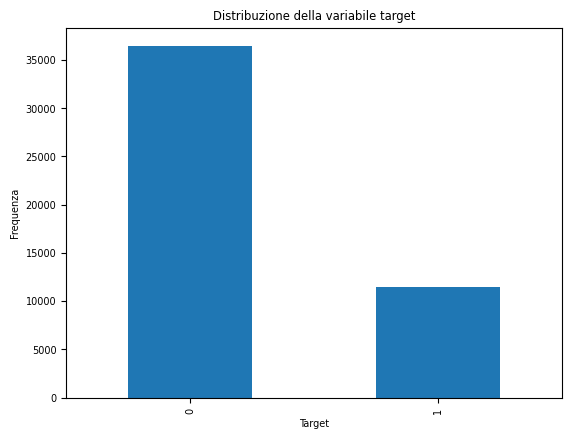

In [ ]:
conteggio_valori = df['target'].value_counts()
print(conteggio_valori)

conteggio_valori.plot(kind='bar')
plt.title('Distribuzione della variabile target')
plt.xlabel('Target')
plt.ylabel('Frequenza')
plt.show()

### Codifica colonna 'sex'

Verifichiamo che gli unici valori siano 'male' e 'female'

In [ ]:
df['sex'].unique()

array(['Male', 'Female'], dtype=object)

Codifichiamo 'female' con 0 e 'male' con 1

In [ ]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48808,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,0,0,0,36,United-States,0
48809,64,unknown,321403,HS-grad,9,Widowed,unknown,Other-relative,Black,1,0,0,40,United-States,0
48810,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,1,0,0,50,United-States,0
48811,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,1,5455,0,40,United-States,0


In [ ]:
df['sex'] = df['sex'].astype('int64')

df['sex'].unique()

array([1, 0], dtype=int64)

### Ricerca correlazione tra 'education' e 'education-num'

Prima di procedere occorre stabilire il corretto ordine del livello di educazione. Se il contenuto di education-num è più intuitivo (nel senso che l'ordine è quello numerico), per il contenuto di education occorre informarsi sul sistema scolastico americano. L'ordine corretto dal livello minore a quello maggiore quindi è: Preschool, 1st-4th, 5th-6th, 7th-8th,9th, 10th, 11th, 12th, HS-grad, Some-college, Assoc-voc, Assoc-acdm, Bachelors, Masters, Prof-school e infine Doctorate.

Osserviamo su un grafico la corrispondenza


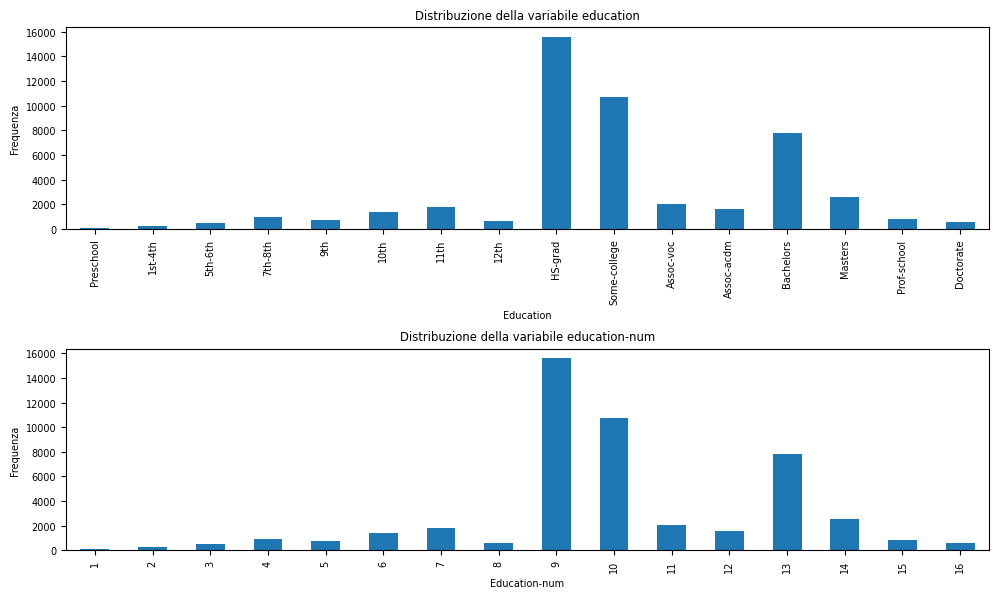

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

education_level_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th','9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']

df['education'].value_counts().loc[education_level_order].plot(kind='bar', ax=axs[0])
axs[0].set_title('Distribuzione della variabile education')
axs[0].set_xlabel('Education')
axs[0].set_ylabel('Frequenza')

df['education-num'].value_counts().sort_index().plot(kind='bar', ax=axs[1])
axs[1].set_title('Distribuzione della variabile education-num')
axs[1].set_xlabel('Education-num')
axs[1].set_ylabel('Frequenza')

plt.tight_layout()
plt.show()

Creo un dataframe copia contenente solo le colonne 'education' e 'education-num' con cui lavorare

In [ ]:
education_df = df[['education', 'education-num']].copy()

print(education_df['education-num'].value_counts())
print(education_df['education'].value_counts())

education_df.head()

9     15580
10    10714
13     7810
14     2578
11     2037
7      1800
12     1579
6      1372
4       930
15      808
5       745
8       634
16      562
3       489
2       238
1        81
Name: education-num, dtype: int64
HS-grad         15580
Some-college    10714
Bachelors        7810
Masters          2578
Assoc-voc        2037
11th             1800
Assoc-acdm       1579
10th             1372
7th-8th           930
Prof-school       808
9th               745
12th              634
Doctorate         562
5th-6th           489
1st-4th           238
Preschool          81
Name: education, dtype: int64


,education,education-num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13


Trasformiamo in tipo numerico il contenuto della colonna education associando ad ogni livello di istruzione un numero da 1 a 16 come la colonna education-num

In [ ]:
mapping = {'Preschool':1, '1st-4th':2, '5th-6th':3, '7th-8th':4,'9th':5, '10th':6, '11th':7, '12th':8, 'HS-grad':9, 'Some-college':10, 'Assoc-voc':11, 'Assoc-acdm':12, 'Bachelors':13, 'Masters':14, 'Prof-school':15, 'Doctorate':16}

education_df['education'] = education_df['education'].replace(mapping)

education_df.head()

,education,education-num
0,13,13
1,13,13
2,9,9
3,7,7
4,13,13


In [ ]:
education_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47957 entries, 0 to 48812
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   education      47957 non-null  int64
 1   education-num  47957 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


Osserviamo la correlazione tra le due colonne: se è uguale a 1 significa che le due colonne sono identiche, pertanto potremo eliminare una delle due per evitare ridondanza tra i dati

In [ ]:
education_df.corr().style.background_gradient(cmap='coolwarm')

,education,education-num
education,1.000000,1.000000
education-num,1.000000,1.000000


Procediamo ad eliminare la colonna 'education'. Manteniamo 'education-num' poichè il tipo numerico è più semplice da gestire

In [ ]:
df = df.drop('education', axis=1)

### Fusione delle colonne 'capital gain' e 'capital loss'

Creiamo una solo colonna che include perdite e guadagni e che si chiamerà 'net-capital'. Il risultante di questa colonna è la sottrazione tra i guadgni e le perdite. Se il valore è positivo abbiamo un guadagno, se è negativo abbiamo una perdita. In questo modo riusciamo a ridurre di un'altra feature il dataset.

In [ ]:
df['net-capital'] = df['capital-gain'].subtract(df['capital-loss'])
df = df.drop(labels=['capital-gain', 'capital-loss'], axis=1)

df

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,target,net-capital
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,1,40,United-States,0,2174
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,1,13,United-States,0,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,1,40,United-States,0,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,40,United-States,0,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,40,Cuba,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48808,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,0,36,United-States,0,0
48809,64,unknown,321403,9,Widowed,unknown,Other-relative,Black,1,40,United-States,0,0
48810,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,1,50,United-States,0,0
48811,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,1,40,United-States,0,5455


### Bilanciamento della colonna 'target' con 'SMOTE'

Siccome il nostro dataset è sbilanciato procederemo con la tecnica di oversampling 'SMOTE'

In [ ]:
'''smote = SMOTE(sampling_strategy='minority')

X_resampled, y_resampled = smote.fit_resample(X, y)

print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_resampled))'''

"smote = SMOTE(sampling_strategy='minority')\n\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\nprint('Original dataset shape %s' % Counter(y))\nprint('Resampled dataset shape %s' % Counter(y_resampled))"